# Setup

In [1]:
import pandas as pd
import numpy as np
import scipy
import nltk

import re
import random
import time
import string
import pickle
import itertools
from typing import *
from collections import defaultdict, Counter

In [ ]:
# For reproducibility
SEED = 10
random.seed(SEED)
np.random.seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# Display the entire text
pd.set_option("display.max_colwidth", None)

**Note**: I tested my code in **local**, therefore it might happen that some result is different in Colab, even with the same random seed. 

# 1. Pre-processing

The dataset is the [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews). I only used the textual information from the reviews to compute the similarity. 

In [ ]:
dataset_path = "./datasets/reviews.csv"
# Create a Pandas DataFrame
df = pd.read_csv(dataset_path, sep = ',') 

Get only the text from the dataset.

In [4]:
df_text = df['Text']

By applying multiple times the method `sample` we can notice that the dataset is pretty 'dirty', as it contains HTML tags, URLS, non-english characters etc. 

In [5]:
df_text.sample(5)

160375                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Before the cleaning process, it is important to convert contractions in their extended form in order to reduce the vocabulary dimension.

In [6]:
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

In [7]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

class TextCleaner:
    def __init__(self, df_text: pd.DataFrame, contractions_dict: Optional[ Dict[str, str] ] = None):
        self.df_text = df_text

        # Contractions
        self.contractions_dict = contractions_dict

        # URL pattern
        self.url_pattern = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
        self.htlm_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

        # Emoji pattern
        self.emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)

        # Punctuation
                                    # The last two dashes seem the same but actually the are not.
        self.punctuation = list(string.punctuation) + ["‘","’", "“", "”", "–", "―", "—"]

        # Stopwords
        self.stop_words = nltk.corpus.stopwords.words('english') 
        

    def clean_df(self, do_lemmatization):
        df_text_clean = self.df_text.apply(self.clean_text, args=(do_lemmatization,) )    
        return df_text_clean

    def clean_text (
        self,
        text: str, 
        do_lemmatization: bool = False,
        do_stemming: bool = False,
    ) -> str:

        """
        Returns
        -------
            A 'cleaned' string, where are removed HTML, URLS, emoji, 
            punctuation, stopword and numbers. It can also be
            lemmatized or stemmed.
            
        Parameters
        ----------
        text: str
            The string to be cleaned. In this case, a sentence from the dataset.
        
        do_lemmatization: bool
            If True the text is also lemmatize.
        
        do_stemming: bool
            If True the text is also stemmatize.    
        """

        text = str(text).lower()
        
        # Remove HTML
        text = self.htlm_pattern.sub(r'', text)
        text = self.url_pattern.sub(r'', text)
        
        # Remove Emoji
        text = self.emoji_pattern.sub(r'', text)
        
        # Remove contractions
        if contractions_dict is not None:
            text = ' '.join([contractions_dict[token] if token in self.contractions_dict else token for token in text.split()])
        
        # Remove punctuation
        text = ''.join([punc for punc in text if punc not in self.punctuation])
        
        # Remove stopwords
        text = ' '.join([word for word in text.split() if word not in self.stop_words])

        # Remove numbers
        text = re.sub("\d+", "", text)

        # Lemming
        if do_lemmatization:
            lemmatizer = WordNetLemmatizer()
            text_lemmatize = [lemmatizer.lemmatize(token) for token in text.split()]
            text = ' '.join(text_lemmatize)

        # Stemming: e.g., history --> histori, historical --> histori
        if do_stemming:
            stemmer = PorterStemmer() 
            text_stemmed = [stemmer.stem(word) for word in text.split()]
            text = ' '.join(text_stemmed)

        # Remove strings with one or two characters only
        text = ' '.join([l for l in text.split() if len(l) >= 3])

        return text.strip() # Remove all the useless space

In [8]:
text_cleaner = TextCleaner(df_text, contractions_dict)

In [9]:
df_text_cleaned = text_cleaner.clean_df(do_lemmatization=True)

In [3]:
path_cleaned_text = "./datasets/cleaned_text.csv"

I decided to save the cleaned dataset to disk, to avoid the cleaning operation to be executed every time.

You can directly import the dataset from the next cell.

    df_text_cleaned.to_csv(path_or_buf=path_cleaned_text, index_label=False)

In [4]:
df_text_cleaned = pd.read_csv(path_cleaned_text, sep = ',')['Text'] 

I check if after the pre-processing some reviews got completely delete because with a lot of noise.

In [14]:
idx_null_text_after_cleaning = df_text_cleaned[df_text_cleaned.isnull()].index
idx_null_text_after_cleaning

Int64Index([188001, 233938, 299605, 324249, 378643, 388831, 487863, 544869], dtype='int64')

In [17]:
df_text[idx_null_text_after_cleaning]

188001                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        v e r y g o o d v e r y g o o d v e r y g o o d v e r y g o o d
233938    

I remove these reviews.

In [5]:
df_text_cleaned = df_text_cleaned[~df_text_cleaned.isnull()]

Now, I want to check if there are duplicates in the dataset. Since I am looking for similar reviews, I want to delete all the possible duplicates, in order to avoid useless computation later on.

A trick I can use to figure out if there are duplicates is to use a Python Counter dictionary applied directly on the text. In this way, I will know if a phrase appear more than ones.

In [36]:
any(df_text_cleaned.duplicated())

True

In [26]:
counter = Counter(df_text_cleaned)

In [30]:
text_frequency = dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))

In [34]:
review_to_print = 10
for review, freq in text_frequency.items():
    if review_to_print == 0:
        break

    print(freq)
    review_to_print -= 1


199
126
51
45
42
41
38
36
35
34


In [6]:
print(f"Number of duplicates: {sum(df_text_cleaned.duplicated())}")

Number of duplicates: 175480


As we can see, there are a lot of duplicates.

In [7]:
print(f"Number of reviews before: {df_text_cleaned.shape[0]}")

Number of reviews before: 568446


There are a lot of duplicates (175487) so I'll remove them.

In [8]:
df_text_cleaned.drop_duplicates(inplace=True)

In [9]:
print(f"Number of reviews after: {df_text_cleaned.shape[0]}")

Number of reviews after: 392966


Keep track of the indices in the original dataframe by having a map from the new indices to the old ones.

In [10]:
map_idx_new_to_old = dict(df_text_cleaned.reset_index()['index'])

In [11]:
df_text_cleaned.reset_index(drop=True, inplace=True)

# 2. Locality Sensitive Hashing Analysis

After the pre-processing, I reduced the dataset and vocabulary dimensions. This has a positive impact on the following computation!  

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

I can vectorize the dataset, by computing the TF-IDF vectors of each review.

In [13]:
vectorizer = TfidfVectorizer(stop_words='english') 
X_tfidf = vectorizer.fit_transform(df_text_cleaned)

In [14]:
X_tfidf.shape

(392966, 297509)

The **L**ocality **S**ensitive **H**ashing (LSH) technique is based on the idea of mapping items onto buckets, with the goal of having *similar* items on the same bucket with high probabiliy. *Similar* in this case means having a cosine similarity over the threshold. A bucket can be seen as a set that belong to a hash table. 

Ideally we want to have similar elements in the same bucket and the non-similar ones on different buckets.


Therefore, it is required a function (hash function $h$) that when applied to two vectors $x, y\in {\rm I\!R}^d$, if they are similar ($sim(x, y) \ge \theta$), they will have with high probability the same value:
$$
P(h(x) = h(y)) \ge P_1
$$
and vectors that are far apart ($sim(x, y) \le c\theta$) will have different value:
$$
P(h(x) = h(y)) \le P_2
$$
with $P_2 < P_1$ and $c < 1$.

In the case of **cosine similarity**, the function is:
$$
h_u(x) = sign(u \cdot x)
$$
where $u \in {\rm I\!R}^d$ is a random unit vector, which defines an hyperplane.

The idea is to generate uniformly at random $m$ hyperplanes that divide the space, so that for a particular hyperplane, a point in this space ends up in one of the two regions which the plane separates. Thus, we have that the closest two points are, the more likely they will be on the same region for a random hyperplane. 


The probability that two vectors, as above, hash to the same value is:
$$
p = P(h(x) = h(y)) = 1 - \frac{\arccos(sim(x, y))} {\pi}
$$ 

Once the hash value (signature) of a vector is computed, we can divide it in $b$ bands, each one containing $r$ rows.

Now, a pair of reviews is consider a candidate pair, so similar, if and only if they have the same values on all in at **least one band**.

The probability that for at least one band all the hashes are equal for a pair of two reviews is:
$$
P_{sim} = 1 - (1 - p^r) ^ b
$$

## 2.1 Fixing the Threshold

Sample uniformly at random the 1% of the documents.

In [73]:
_, X_tfidf_threshold = train_test_split(X_tfidf, test_size=0.01, random_state=SEED)

In [74]:
X_tfidf_threshold.shape

(3930, 297509)

Compute the average pairwise cosine similarity between the selected reviews.

In [75]:
similarities_for_threshold = cosine_similarity(X_tfidf_threshold, X_tfidf_threshold, dense_output=False)

In [80]:
print(f"Sampled average pairwaise cosine similarity: {np.mean(similarities_for_threshold):.5f}")
times = 39
print(f"{times} x Sampled average pairwaise cosine similarity: {np.mean(similarities_for_threshold) * times:.5f}")

Sampled average pairwaise cosine similarity: 0.01692
39 x Sampled average pairwaise cosine similarity: 0.65969


I select the threshold $\theta$ equal to 0.65, therefore I consider two reviews to be **similar** when they have a cosine similarity greater than $\theta$.

In [15]:
theta = 0.65

In order to show how changes the threshold when the $b$ and $r$ vary, I plotted $P_{sim}$.

In [83]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.transforms as transforms


def plot_lsh_curve(p, rows=5, bands=24):
    x = np.linspace(0, 1, num=500)
    P = lambda x: 1 - (1 - x**rows)**bands
    
    _, ax = plt.subplots(figsize=(8, 6), dpi=80)

    ax.plot(x, P(x))
    ax.axvline(p, linestyle="--", color="r", label="Threshold")

    trans = transforms.blended_transform_factory(
        ax.get_xticklabels()[0].get_transform(), ax.transData)
    ax.text(p + 0.005, -0.13, "p", color="red", transform=trans, 
            ha="right", va="center", fontsize=12)

    ax.fill_between(x, P(x), where=x < p,  step="pre", alpha=0.5, label="False Positives")
    ax.fill_betweenx(P(x), x, p, where=P(x) > P(p), step="mid", alpha=0.4, color="r", label="False Negatives")

    plt.legend(loc="upper left")
    plt.ylabel('Probability Sharing Bucket', fontsize=12)
    plt.xlabel('Similarity', fontsize=12)
    ax.xaxis.set_label_coords(.5, -0.1)
    plt.grid()
    plt.show()
    


In [87]:
p = 1 - np.arccos(theta) / np.pi
p

0.7252311215194696

The graph is such that:
$$
p \sim \left ( \frac{1}{b} \right )^{\frac{1}{r}}
$$

680 0.8049356770309067


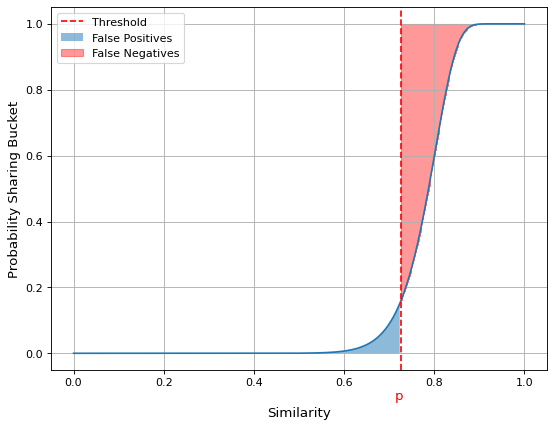

In [85]:
r = 17
b = 40

print(r * b, (1/b) ** (1/r))
plot_lsh_curve(p, r, b)

After some trials I chose those values for $r$ and $b$, as it computationally feasible and it does not include too many false positives in the LSH buckets.

## 2.2 Compute Signatures

In [16]:
class HashTable:
    def __init__(self, signature_size: int, inp_dimensions: int):
        self.signature_size = signature_size
        self.projections = np.random.randn(self.signature_size, inp_dimensions)
    
    def generate_hash(self, inp_vector: Union[ scipy.sparse.csr.csr_matrix, np.ndarray ] ):
        # If the dot product is greater than 0, we have a 1, otherwise a 0.
        one_hot_signature = (inp_vector @ self.projections.T > 0).astype(np.uint8)
        return [''.join(signature.astype(str)) for signature in one_hot_signature]
    

In [17]:
rows = 17
bands = 40

signature_size = rows * bands
inp_dimensions = X_tfidf.shape[1]

In [18]:
cosine_hash = HashTable(signature_size, inp_dimensions)

Return Signature: 2m 30s

In [19]:
signatures = cosine_hash.generate_hash(X_tfidf)

I save the signatures via `pickle`.

    with open('sig_17_40.pkl', 'wb') as f:
        pickle.dump(signatures, f, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('sig_17_40.pkl', 'rb') as f:
    signatures = pickle.load(f)

I split the original dataset into training and test sets at the beginning to store their indices, so I will not lose the reference after the analysis. I consider the 0.7% of the reviews as test set.

In [20]:
df_text_train, df_text_test = train_test_split(df_text_cleaned, test_size=0.007, random_state=SEED)

In [21]:
train_idxs = df_text_train.index.sort_values()
test_idxs = df_text_test.index.sort_values()

In [22]:
X_tfidf_train = X_tfidf[train_idxs]
X_tfidf_test = X_tfidf[test_idxs]

In [23]:
print(f"Training dimension: {df_text_train.shape[0]}")
print(f"Test dimension: {df_text_test.shape[0]}")

Training dimension: 390215
Test dimension: 2751


## 2.3 LSH Computation

I tried to consider the efficient ways to compute the buckets for LSH. The first and intuitive approach is of course using Python sets to store review indices for a given combination of bits. However, when the number of rows to be consider is small (rows < 8), Python sets become quite inefficient in storing indices and in particular in the later computation of the B set for the test reviews. The reason why is that there are so many reviews sharing that given number of bits, thus they will be part of the same set. 

Therefore, I decided to implement also another approach that is base on NumPy arrays. These arrays are very efficient in accessing their elements and for matrix calculations. When the number of rows is small (rows < 8), it is convenient to use this method, as the the number of similar reviews is pretty high, so the matrix will be almost dense. In this case, the array will have dimension ( len(signatures) ) and initialized with zeros; in such a way that, for a given sequence of bits of a particular review, there will be a 1 in the position of that review.

In [24]:
class LSH:
    def __init__(self, bands: int, rows: int, matrix_form: bool=False):
        self.bands = bands
        self.rows = rows
        self.matrix_form = matrix_form

        # The dictionaries will contain numpy arrays
        if matrix_form:
            self.dictionaries = [defaultdict(np.ndarray) for _ in range(bands)]
            self.bits_combinations = ["".join(bits) for bits in itertools.product(['0', '1'], repeat=self.rows)] 
        
        else: # The dictionaries will sets
            self.dictionaries = [defaultdict(set) for _ in range(bands)]
        

    def compute_dictionaries(self, signatures: Union[ List[str], np.ndarray ]):
        # Initialize numpy arrays
        if self.matrix_form:
            for d in self.dictionaries:
                for bits in self.bits_combinations:
                    d[bits] = np.zeros(len(signatures), dtype=np.uint8)

        # For every signature
        for idx, sig in enumerate(signatures):
            # For every bucket (dictionary)
            for i in range(self.bands):
                # Get 'self.rows' bits from the signature and hash them
                bits_in_band = sig[i * self.rows : self.rows * (i + 1)]

                if self.matrix_form:
                    self.dictionaries[i][bits_in_band][idx] = 1

                else:
                    # Add the signature index (equivalently, the review index) to the i-th dictionary
                    self.dictionaries[i][bits_in_band].add(idx)

  

In [25]:
lsh = LSH(bands, rows)

In [26]:
np_signatures = np.array(signatures)
# Get training signatures
train_signatures = np_signatures[train_idxs]

The following cell will compute the buckets for the training signatures.

In [27]:
start_buckets = time.time()
lsh.compute_dictionaries(train_signatures)
end_buckets = time.time()

In [28]:
print(f"Time required to compute buckets: {end_buckets - start_buckets:.3f}s")

Time required to compute buckets: 17.945s


Save the dictionaries:

    with open('dict_17_40.pkl', 'wb') as f:
        pickle.dump(lsh.dictionaries, f, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open('dict_17_40.pkl', 'rb') as f:
    lsh.dictionaries = pickle.load(f)

In [29]:
d = lsh.dictionaries[0]
num_values_in_dict = sum(len(v) for k, v in d.items())
print("Average number of reviews in one band:", num_values_in_dict / len(d))

Average number of reviews in one band: 3.2961523841702918


In [30]:
batch_size = 250

In [31]:
theta = 0.65

## 2.4 Exact Cosine Similarity

The exact cosine similarity for computing the set A can be efficiently performed by batching the reviews. Once a batch is computed, it is stacked with the previous ones. Moreover, even if the matrix is dense it is memory efficient, since I will only store booleans, resulting from `reviews_similarity > theta`. 

In [32]:
def compute_exact_stacked_similarity(
    X_tfidf_test: scipy.sparse.csr.csr_matrix, 
    X_tfidf_train: scipy.sparse.csr.csr_matrix, 
    theta: float,
    batch_size: int=250
) -> Dict[int, set]:
    
    # First batch
    reviews_similarity = cosine_similarity(X_tfidf_test[:batch_size], X_tfidf_train, dense_output=True)
    stacked_similarities = reviews_similarity > theta

    # Remaining batches
    for i in range(batch_size, X_tfidf_test.shape[0], batch_size):
        test_reviews = X_tfidf_test[i : i + batch_size]

        # Compute cosine
        reviews_similarity = cosine_similarity(test_reviews, X_tfidf_train, dense_output=True)
        # Stack to the previous batches
        stacked_similarities = np.vstack([stacked_similarities, reviews_similarity > theta])

    return stacked_similarities
    

In [33]:
def compute_exact_similarity(
    stacked_similarities: np.ndarray, 
    test_idxs: np.ndarray,
    train_idxs: np.ndarray,
) -> Dict[int, set]:
    
    exact_similarity_A = defaultdict(set)

    # 'similar_over_threshold' is a numpy array of boolean.
    # It is True in the indices for which the cosine resulted greater than theta.
    for review_idx, similar_over_threshold in enumerate(stacked_similarities):
        # Map to the indices in the original dataset
        test_review_original_idx = test_idxs[review_idx]
        
        # Get indices of the similar reviews in the training set
        similar_in_train_idxs = np.argwhere(similar_over_threshold).squeeze()
        
        if similar_in_train_idxs.size > 1:
            # Map to the indices in the original dataset
            train_reviews_original_idxs = map(lambda idx: train_idxs[idx], similar_in_train_idxs)
            exact_similarity_A[test_review_original_idx] = set(train_reviews_original_idxs)
        elif similar_in_train_idxs.size == 1:
            exact_similarity_A[test_review_original_idx] = {train_idxs[similar_in_train_idxs]}
        else:
            exact_similarity_A[test_review_original_idx] = set()

    return exact_similarity_A

In [34]:
start_A = time.time()
stacked_similarities = compute_exact_stacked_similarity(X_tfidf_test, X_tfidf_train, theta)
exact_similarity_A = compute_exact_similarity(stacked_similarities, test_idxs, train_idxs)
end_A = time.time()

In [35]:
print(f"Time required to compute A with the exact cosine similarity: {end_A - start_A:.3f}s")

Time required to compute A with the exact cosine similarity: 30.362s


In [37]:
non_empty = 0
for idx, s in exact_similarity_A.items():
    if len(s) != 0:
        print(idx, s)
        non_empty += 1

2023 {2069}
7790 {371878, 556, 160524, 252630, 48503}
8449 {66155}
11136 {196533}
12070 {259490}
15158 {67459, 71497, 220909, 233652, 15220}
16188 {197408}
17683 {297144, 89733, 151886}
20306 {80228, 38660, 312073, 8013, 185748, 52062}
21925 {9813, 97686}
22932 {123302, 22974}
24568 {85538}
24924 {121848, 98303}
28680 {205026, 238530, 238500, 28777, 153673, 28844, 153741, 238621, 153688, 28826, 153788, 28701, 28830, 28798}
28746 {260152}
32721 {374510, 91505, 123666, 362615, 29144, 29566}
36924 {306497, 111979}
38631 {11641, 98700}
39364 {124400, 103057, 171525, 147169}
39806 {232768, 39789, 39790, 39791, 155380, 39797, 203125, 39643, 39613, 39615}
48487 {97891}
48878 {281260}
50381 {70612}
52099 {208919}
55053 {3842}
55258 {55217, 55257, 55205}
57206 {214305}
57246 {57257}
58979 {238972, 250415}
60216 {312352, 115106, 294255, 271759, 312310, 95670, 335702, 381306, 312350}
60547 {237528}
61680 {277118}
65240 {377395}
65842 {95185}
69869 {69863}
73197 {291130}
79375 {156223}
83154 {3034

In [38]:
non_empty / len(test_idxs)

0.04689203925845147

With that value of theta, only 4% of the test reviews have a similar in the training set.

Save A:

    with open('A_065.pkl', 'wb') as f:
        pickle.dump(exact_similarity_A, f, protocol=pickle.HIGHEST_PROTOCOL)
    

In [43]:
with open('A_65.pkl', 'rb') as f:
    exact_similarity_A = pickle.load(f)

Let's see if the exact computation of the similarities is correct for some reviews: 

In [105]:
# This two are considered similar
print(df_text_cleaned[121848])
print(df_text_cleaned[98303])

good grapefruit juice fact best grapefruit juice ever take long pack however product buy cost
grapefruit flavor sparkling water simply delicious refreshing really taste like grapefruit juice better also orange mango good favorite grapefruit


Indeed they are similar.

In [108]:
print(df_text_cleaned[306497])
print(df_text_cleaned[111979])

buy coffee enjoy great strong tasting coffee
love coffee add small amount regular coffee really make great tasting cup coffee


## 2.5 LSH Similarity

In [40]:
def compute_lsh_similarity(
    lsh: LSH,
    test_signatures: Union[ List[str], np.ndarray ], 
    test_idxs: np.ndarray, 
    rows: int,
    bands: int,
    
) -> Dict[int, set]:

    lsh_similarity_B = defaultdict(set)
    for review_idx, sig in enumerate(test_signatures):
        # Map to the indices in the original dataset
        test_review_original_idx = test_idxs[review_idx]
        
        for i in range(bands):
            bits_in_band = sig[i * rows : rows * (i + 1)]              # The training indices are the correct ones wrt the original dataset
            lsh_similarity_B[test_review_original_idx] = lsh_similarity_B[test_review_original_idx].union(lsh.dictionaries[i][bits_in_band])

    return lsh_similarity_B
    

In [41]:
test_signatures = np_signatures[test_idxs]

In [42]:
start_B = time.time()
lsh_similarity_B = compute_lsh_similarity(lsh, test_signatures, test_idxs, rows, bands)
end_B = time.time()

In [43]:
print(f"Time required to compute B with the LSH method: {end_B - start_B:.3f}s")

Time required to compute B with the LSH method: 0.364s


# 3 Comparisons between A and B

Now, it is possible to compare the sets obtained from the exact compution A and the ones from the LSH method B. I will average the jaccard similarities between the sets of each test review. I also consider the case 'is_subset' to count how many elements of a set in A are in B. In this way, I am computing the number of reviews that are considered similar by the LSH approach and that are indeed similar. Therefore, it is a metric for the **recall**, as it counts the number of correctly predicted reviews. 

In [44]:
jaccards = {}
is_subset = {}

In [45]:
for review_idx in test_idxs:
    union = exact_similarity_A[review_idx] | lsh_similarity_B[review_idx]
    intersection = exact_similarity_A[review_idx] & lsh_similarity_B[review_idx]

    # When the union is 0, the two sets are empy therefore the jaccard is 1
    jaccards[review_idx] = 1 if len(union) == 0 else len(intersection) / len(union)
    
    if len(exact_similarity_A[review_idx]) == 0:
        # If also the lsh set is empty, the is_subset metric is 1, otherwise 0
        is_subset[review_idx] = 1 if len(lsh_similarity_B[review_idx]) == 0 else 0
    else:
        is_subset[review_idx] = len(intersection) / len(exact_similarity_A[review_idx])

In [46]:
print(f"Jaccard mean: {np.mean(list(jaccards.values()))}")

Jaccard mean: 1.8451988847617938e-06


In [47]:
print(f"Recall mean: {np.mean(list(is_subset.values()))}")

Recall mean: 2.4233612019871563e-05


The results show that A and B are not similar as the Jaccard is approximately 0. The number is so small, also because I have removed all the duplicates from the dataset, thereby the number of possible similars decreases consistently. 

Even though I tried many configurations for b and r, the results did not change much. This is one of the best configuration I found.

When I considered a small number of rows (r= 2,..7) to increase recall (against precision), the computation of B took so long that either did not fit in main memory or A was much faster to compute. For this reason I thought to the matrix approach using NumPy. But of course when the number of rows increases, the matrix becomes exponentially large and so it is not feasible anymore. I did not tried to make it sparse thanks to Scipy. I avoid sparsity in this case because it would be more difficult to keep the reference with the indices to the original dataset.

### Time Comparisons

LSH:

- Computation of signatures: 2m 30s
- Computation of buckets: 18s
- Computation of B: 0.3s

Exact:

- Computation of A: 30s

If we exclude the pre-processing of the signatures, the LSH method is faster (**18.3s** < **30s**) than the exact computation with this configuration of $m = bands \cdot rows = 40 \cdot 17 = 680$.

Now, it follows the NumPy approach, but I did not test it so much.

When the dictionaries are in matrix form `LSH(bands, rows, matrix_form=True)`, we store NumPy arrays instead of Python sets. In this case, for a given test review, I can see which training reviews fall in its bucket by summing up, columm by column, all the arrays associated with this test review, i.e., the arrays at index `lsh.dictionaries[i][bits_in_band]`. I remember that each bucket array only contains binary values, where there is a 1 in the position of the training review that resides in that bucket. Therefore, when I consider a test review, I am interested in the buckets it should fall into, by considering 'rows' bits at a time of its signature. So, there will be 'bands' arrays for a given test review. 

If I sum up all these arrays I will obtain an array that has non-zero values in the positions of the training reviews that appear in all those arrays. In other words, the sum expresses the union of sets.

The advantage of this is that summation of NumPy arrays is really efficient, more than union set, if the matrix is dense or partially dense.

In [ ]:
test_similarities = np.zeros((len(test_idxs), len(train_idxs)), dtype=np.uint32)

for review_idx, sig in enumerate(test_signatures):
    # Map to the indices in the original dataset
    test_review_original_idx = test_idxs[review_idx]
    
    for i in range(bands):
        bits_in_band = sig[i * rows : rows * (i + 1)]
        test_similarities[review_idx] = np.sum([test_similarities[review_idx], lsh.dictionaries[i][bits_in_band]], axis=0)

In [ ]:
stacked_similarities = compute_exact_stacked_similarity(X_tfidf_test, X_tfidf_train, theta)

`logical_and` and `logical_or` convert in booleans the values of the matrices. Thus, all the non-zero value will be True and the zero values False. Then, if you sum up the cells that give True for the intersection, we will get the cardinality of the intersection, so the numerator of the Jaccard. On the other hand, the sum on the union will result into the denominator of the Jaccard. 

In [ ]:
intersection = np.logical_and(test_similarities, stacked_similarities) 
union = np.logical_or(test_similarities, stacked_similarities)

print(f"Jaccard mean: {intersection.sum() / float(union.sum())}")